# LSTM model

### Import Library

In [ ]:
import zipfile
import os

import numpy as np

!pip install pydub
from pydub import AudioSegment, effects
import librosa

!pip install noisereduce
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display   
import IPython.display as ipd

import tensorflow as tf
import keras
import sklearn

from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Insert Database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive

# data_dir = '/content/drive/MyDrive/achieve.zip'
# zip_train = zipfile.ZipFile(data_dir, 'r')
# zip_train.extractall('/content/drive/MyDrive/achieve')
# zip_train.close()

DATADIR1 = "/content/drive/MyDrive/CE4042Input"
DATADIR2 = "/content/drive/MyDrive/CE4042Input/emodb"

Mounted at /content/drive
MyDrive


### Data Pre-processing

In [ ]:
# To get the maximum unsilent audio length 
maxLength=228864 # The result get aft running the below commented code

# i=0
# for folders in os.listdir(DATADIR1):
#   path = os.path.join(DATADIR1, folders)
#   for files in os.listdir(path):
#     file = os.path.join(path, files)
#     if file[-4:] == '.wav':
#       x, sr = librosa.load(file, sr = None)
#       rawsound = AudioSegment.from_file(file)
#       normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
#       normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
#       xt, index = librosa.effects.trim(normal_x, top_db=30)
      
#       # print(i, end=" ")
#       # print(maxLength, end=" ")
#       # print(len(xt))
#       # i=i+1
      
#       if maxLength<len(xt):
#         maxLength=len(xt)
# print('Maximum sample length of the audio file: ',maxLength)
                
# i=0
# for files in os.listdir(DATADIR2):
#   file = os.path.join(DATADIR2, files)

#   if file[-4:] == '.wav':
#     x, sr = librosa.load(file, sr = None)
#     rawsound = AudioSegment.from_file(file)
#     normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
#     normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
#     xt, index = librosa.effects.trim(normal_x, top_db=30)
    
#     print(i, end=" ")
#     print(maxLength, end=" ")
#     print(len(xt))
#     i=i+1
    
#     if maxLength<len(xt):
#       maxLength=len(xt)
# print('Maximum sample length of the audio file: ',maxLength)
                

In [ ]:
# Encoder the labels 
def encoderD1 (label):
  if label == "01":   return 0 # neutral
  elif label == "02": return 1 # calm
  elif label == "03": return 2 # happy
  elif label == "04": return 3 # sad
  elif label == "05": return 4 # angry
  elif label == "06": return 5 # fear
  elif label == "07": return 6 # disgust
  elif label == "08": return 7 # suprised
  else: return -1

# emodb
def encoderD2 (label):
  if label == "N":   return 0 # neutral
  elif label == "F": return 2 # happy
  elif label == "T": return 3 # sad
  elif label == "W": return 4 # angry
  elif label == "A": return 5 # fear
  elif label == "E": return 6 # disgust
  elif label == "L": return 8 # boredom
  else: return -1

In [ ]:
frame_length = 2048
hop_length = 512

def data_preprocessing(file):
  x, sr = librosa.load(file, sr = None)
  # 1. Load the audio file into an 'AudioSegment' object, and extract the sample rate. 
  rawsound = AudioSegment.from_file(file)
  # 2. Normalize to +5.0 dBFS, Transform audio signals to an array.
  normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
  normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
  # 3. Trim silence in the beginning and end.
  xt, index = librosa.effects.trim(normal_x, top_db = 30)
  # 4. Right-side padding for length equalization.
  padded_x = np.pad(xt, (0, maxLength-len(xt)), 'constant')
  # 5. Noise reduction
  final_x = nr.reduce_noise(y=padded_x, 
                            y_noise=padded_x,
                            sr=sr)
  return final_x, sr

def feature_extraction(file, sr):
  f = []
  f.append(librosa.feature.rms(file, frame_length=frame_length, hop_length=hop_length)) # Energy - Root Mean Square   
  f.append(librosa.feature.zero_crossing_rate(file , frame_length=frame_length, hop_length=hop_length, center=True)) # ZCR      
  f.append(librosa.feature.mfcc(file, sr=sr, n_mfcc=13, hop_length = hop_length)) # MFCC
  # f.append(librosa.feature.chroma_stft(file, sr=sr, n_fft=2048, hop_length=hop_length))
  # f.append(librosa.feature.spectral_centroid(file, sr=sr, n_fft=2048, hop_length=hop_length))
  # f.append(librosa.feature.spectral_rolloff(file, sr=sr, n_fft=2048, hop_length=hop_length))
  # f.append(librosa.feature.spectral_bandwidth(file, sr=sr, n_fft=2048, hop_length=hop_length))
  # f.append(librosa.feature.spectral_contrast(file, sr=sr, n_fft=2048, hop_length=hop_length))
  # f.append(librosa.feature.spectral_flatness(file, n_fft=2048, hop_length=hop_length))
  return f


In [ ]:
training_data = []

features = {
            'rms' : [],
            'zcr' : [],
            'mfcc' : [],
            # 'chroma_stft' : [],
            # 'spectral_centroid' : [],
            # 'spectral_rolloff' : [],
            # 'spectral_bandwidth' : [],
            # 'spectral_contrast' : [],
            # 'spectral_flatness' : []
        }


emotions = []

i=0
for folders in os.listdir(DATADIR1):
  print(folders)
  path = os.path.join(DATADIR1, folders)
  for files in os.listdir(path):
    file = os.path.join(path, files)

    file, sr = data_preprocessing(file)
    f_ = feature_extraction(file, sr)
    # Filling the data lists  
    for a in features:
      # print(a,end=' ')
      # print(list(features).index(a))
      # print(f[list(features).index(a)])
      features[a].append(f_[list(features).index(a)])

    if (folders == "emodb"):
      audio_identifiers = files[5]
      emotions.append(encoderD2(audio_identifiers))
    else:
      audio_identifiers = files.split('-')
      emotions.append(encoderD1(audio_identifiers[2]))

Actor_01
Actor_02
Actor_03
Actor_04
Actor_05
Actor_06
Actor_07
Actor_08
Actor_09
Actor_10
Actor_11
Actor_12
Actor_13
Actor_14
Actor_15
Actor_16
Actor_17
Actor_18
Actor_19
Actor_20
Actor_21
Actor_22
Actor_23
Actor_24
emodb


In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)
a_features = {
            'rms' : [],
            'zcr' : [],
            'mfcc' : [],
            # 'chroma_stft' : [],
            # 'spectral_centroid' : [],
            # 'spectral_rolloff' : [],
            # 'spectral_bandwidth' : [],
            # 'spectral_contrast' : [],
            # 'spectral_flatness' : []
        }
for a in features:
  # print(f[list(features).index(a)])
  a_features[a] = np.asarray(features[a]).astype('float32')
  a_features[a] = np.swapaxes(a_features[a],1,2)
  print(f'{a} shape: {a_features[a].shape}')


rms shape: (1975, 448, 1)
zcr shape: (1975, 448, 1)
mfcc shape: (1975, 448, 13)


In [ ]:
# Concatenating all features to 'X' variable.
# f_pitch
X = np.concatenate([a_features[x] for x in a_features], axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions)
Y = np.expand_dims(Y, axis=1)
print(X.shape)
print(Y.shape)

(1975, 448, 15)
(1975, 1)


In [ ]:
for i in range(9):
  print(f'Y {i} {np.sum(Y == i)}')

Y 0 175
Y 1 192
Y 2 263
Y 3 254
Y 4 319
Y 5 261
Y 6 238
Y 7 192
Y 8 81
Y 9 0


In [ ]:
# print(Y)

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_split, y_train, y_split = train_test_split(X, Y, test_size = 0.2, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_split, y_split, test_size = 0.2, random_state = 1)



# x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
# x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 9, dtype = 'int16')
y_val_class = tf.keras.utils.to_categorical(y_val, 9, dtype = 'int16')
y_test_class = tf.keras.utils.to_categorical(y_test, 9, dtype = 'int16')

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(1580, 448, 15)
(316, 448, 15)
(79, 448, 15)


In [ ]:
for i in range(9):
  print(f'y_test {i} {np.sum(y_test == i)}')

y_test 0 7
y_test 1 6
y_test 2 8
y_test 3 8
y_test 4 11
y_test 5 14
y_test 6 13
y_test 7 4
y_test 8 8


### Build LSTM Model

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(128, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(9, activation = 'softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 448, 128)          73728     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 206,473
Trainable params: 206,473
Non-trainable params: 0
_________________________________________________________________
None


### Train Model

In [ ]:

batch_size = 32
epoch = 500

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/CE4042/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=epoch, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      # callbacks = [mcp_save, rlrop])
                      callbacks = [mcp_save, rlrop])


Epoch 1/500
50/50 [==============================] - 18s 198ms/step - loss: 2.1632 - categorical_accuracy: 0.1601 - val_loss: 2.1045 - val_categorical_accuracy: 0.2247 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 8s 160ms/step - loss: 2.0935 - categorical_accuracy: 0.1797 - val_loss: 2.0436 - val_categorical_accuracy: 0.2089 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 9s 174ms/step - loss: 2.0358 - categorical_accuracy: 0.2101 - val_loss: 2.0148 - val_categorical_accuracy: 0.2278 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 9s 174ms/step - loss: 1.9789 - categorical_accuracy: 0.2310 - val_loss: 1.9024 - val_categorical_accuracy: 0.2911 - lr: 0.0010
Epoch 5/500
50/50 [==============================] - 8s 160ms/step - loss: 1.9159 - categorical_accuracy: 0.2582 - val_loss: 1.8679 - val_categorical_accuracy: 0.2753 - lr: 0.0010
Epoch 6/500
50/50 [==============================] - 8s 160ms/step - loss: 1.9005 - categorical_acc

### Model Evaluation

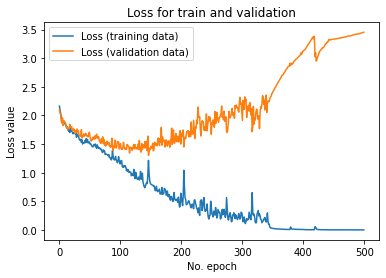

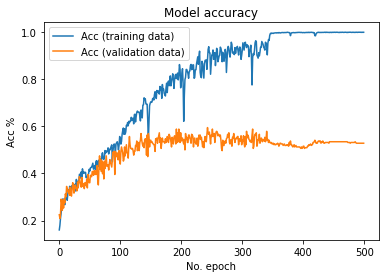

maximum val_accuracy: 0.594936728477478


In [ ]:
# Loss, Accuracy presentation
# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

print("maximum val_accuracy:", np.max(history.history['val_categorical_accuracy']))

In [ ]:
# Define the best weights to the model.
model.load_weights(checkpoint_path)
# Validation score
loss_val, acc_val = model.evaluate(x_val, y_val_class, verbose=2)
# Test score
loss_test, acc_test = model.evaluate(x_test, y_test_class, verbose=2)

10/10 - 1s - loss: 1.8270 - categorical_accuracy: 0.5949 - 688ms/epoch - 69ms/step
3/3 - 0s - loss: 1.6399 - categorical_accuracy: 0.6076 - 218ms/epoch - 73ms/step


# Reference

https://github.com/MeidanGR/SpeechEmotionRecognition_Realtime

https://librosa.org/doc/main/feature.html